Pricing European Call options using the Monte Carlo Simulation

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sympy as smp
import seaborn as sns
from scipy.stats import norm

#### <b>The function will have the following parameters:</b><br>
S0 = initial stock price<br>
K = strike price<br>
T = maturity time (in years)<br>
r = risk free rate<br>
(risk free rate is basically how much money in itself grows over time)
sigma = volatility<br>
n_simulations = no. of Monte carlo simulations<br>
n_steps no. of steps in the simulation<br>

#### <b>Generating paths using Euler-Maruyama discretization</b>

<b>Euler-Maruyama Discretization:</b>
numerical technique to solve stochastic diff eqns (SDEs)<br>
basically, dividing continuous time intervals inro smaller discrete steps<br>
ie, del t with points t0, t1, t2, ......<br>
then, for eah step, value of the process at the next step, say if its step Yn rn, yn+1 is calculated using the previous step's value<br>
ie,<br>
### <b>yn+1 = Yn + b(Yn).del t + sigma(Yn).del Wn</b><br>
##### where b(yn) is the deterministic part of the SDE (r) 
##### and sigma(Yn) is the influence of randomn fluctuations (volatility)

#### The key transformation used to turn the continuous-time GBM into a discrete one is <b>Ito's Lemma</b>

### <b>dS = r.S.dt + sigma.S.dW</b>

### So the GBM discrete-time solution is,

### <b>S(t+dt) = St.e((r-(sigma^2 / 2).dt + sigma.sqrt(dt).Z</b>

#### Z approximately equals N(0, 1), the standard normal distribution

#### where:
#### <b>S_t</b> = option price at time t<br>
#### <b>S_t-1</b> = option price at the previous time<br>
#### <b>r</b> = risk free rate<br>
#### <b>sigma</b> = volatility<br>
#### <b>0.5.sigma^2</b> = correction factor that converts drift from Brownian motion (normal distribution) to a Geometric Brownian motion (log normal distribution)<br>
#### <b>dt</b> = change in time (del t)<br>
#### <b>Sqrt(dt)</b> = this scales the randomn component, acknowleding the fact that the variance of a Brownian motion is proportional to the time passes<br>
#### <b>Z</b> = a randomn variable drawn from a normal istribution, ie mean = 0<br>

<b>so in simple terms,<br>
(r-0.5.sigma^2)dt is what moves the price in a predictible direction over the time steps<br>
and
sigma.sqrt(dt).Z is the stochastic component that adds noise to the price movement, sccountinf for the high volatility of prices<br>

In [ ]:
class european_option_pricer:
    def __init__(self, S0, K, T, r, sigma, n_simulations = 10000, n_steps = 252):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.n_simulations = n_simulations
        self.n_steps = n_steps
        self.dt = T / n_steps # this gives the time each steps would take

    def generate_stock_paths(self):
            #Generate random normal variables (Brownian motion increments)
            Z = np.random.standard_normal((self.n_steps, self.n_simulations))
            # Initialize stock price matrix
            stock_paths = np.zeros((self.n_steps + 1, self.n_simulations))
            stock_paths[0] = self.S0  # initial price
            # using the Euler-Maruyama discretization
            for t in range(1, self.n_steps + 1):
                # we'll be using the GBM formula now
                stock_paths[t] = stock_paths[t-1] * np.exp(
                    (self.r - 0.5 * self.sigma**2) * self.dt +
                    self.sigma * np.sqrt(self.dt) * Z[t-1]
                    )
            return stock_paths
            
    def price_call_option(self):
        stock_paths = self.generate_stock_paths()

        # Getting the price of the stock at the time of maturity (T)
        ST = stock_paths[-1]

        # Calculating the maximum payoff of the option: max(S_T - K, 0)
        call_payoffs = np.maximum(ST - self.K, 0)

        # Discounting the espected payoff to present value
        # $100 now =/ $100 in time (T)
        call_price = np.exp(-self.r * self.T) * np.mean(call_payoffs)

        # Calculating a standard error for the confidence interval
        std_error = np.std(call_payoffs) / np.sqrt(self.n_simulations)

        return call_price, std_error, call_payoffs, stock_paths
        

    def price_put_option(self):
        stock_paths = self.generate_stock_paths()
        
        # Getting the price of a stock at maturity time (T)
        ST = stock_paths[-1]

        # Calculating the price of the stock at the time of maturity
        put_payoffs = np.maximum(self.K - ST, 0)

        # Discounting the expected payoff to the present vialue
        put_price = np.exp(-self.r * self.T) * np.mean(put_payoffs)

        # Calculating a standard error for the confidence interval
        std_error = np.std(put_payoffs) / np.sqrt(self.n_simulations)

        return put_price, std_error, put_payoffs, stock_paths


#### <b> Defining the Black Scholes Merton formula for european call options and using that as a benchmark for the Monte Carlo Simulation model <br>

### <b>C = (S0.phi(d1)) - (K.e^(-rT) .phi(d2))

### <b>P = (K.e^(-r.T) .phi(-d2)) - (S0.phi(-d1))

##### d1 measures how far the current price of the option (S0) is above the strike price (K)
##### i.e. the risk adjusted expeced moneyness (present profitability) of the option

#### <b>d1 = (ln(S0/K) + (r+(sigma^2 /2)).T) / sigma.sqrt(T)

##### d2 represents the risk neutral probability of the option finishing "in the money" after discounting

#### <b>d2 = d1 - signma.sqrt(T)

#### where,
#### S0 = current stock price
#### K = strike price
#### r = risk-free rate
#### sigma = volatility
#### T = time to maturity
#### phi = standard normal CDF

In [15]:
# Black Scholes Merton for calls
def black_scholes_merton_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r +0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

    d2 = d1 - sigma * np.sqrt(T)

    call_price = S0 * norm.cdf(d1) - K*np.exp(-r *T) * norm.cdf(d2)

    return call_price

In [16]:
# Black Scholes Merton for puts
def black_scholes_merton_put(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

    d2 = d1 - sigma * np.sqrt(T)

    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

    return put_price

### The next cell takes option parameters and uses a randomn seed for reproducability

#### <b>more about reproducability</b>: This is just making sure that the randomn number generations are the same each time, so when debugging, the sequence is reproducable. Basically, with the analogy of shuffling cards, without a seed, every shuffle would be different, with a seed the cards are shuffled and you dont know the order beforehand but if you were to shuffle it again it would give you the same order of cards.

##### This cell is an interactive ssection, where the parameters can be changed for parameter testing.

In [17]:
np.random.seed(42)

# Taking the option parameters
S0 = float(input("Enter the current stock price S0 (e.g., 100): "))
K = float(input("Enter the strike price K (e.g., 105): "))
T = float(input("Enter time to maturity T in years (e.g., 1.0): "))
r = float(input("Enter the risk-free rate r (e.g., 0.0470 for 4.70%): "))
sigma = float(input("Enter the volatility sigma (e.g., 0.2 for 20%): "))
n_simulations = int(input("Enter number of Monte Carlo simulations (e.g., 10000): "))

# creating an isntance of the pricer
pricer = european_option_pricer(S0, K, T, r,sigma, n_simulations)

# pricing using the assembled monte carlo simulation
call_price_mc, call_std_error, call_payoffs, stock_paths = pricer.price_call_option()
put_price_mc, put_std_error, put_payoffs,_ = pricer.price_put_option()

# pricing using the analytical black scholes merton model
call_price_bsm = black_scholes_merton_call(S0, K, T, r, sigma)
put_price_bsm  = black_scholes_merton_put(S0, K, T, r, sigma)

A 95% confidence interval is used, as the Monte Carlo price is the best estimate but since the simulation used is randomn, there's uncertanity. Having a 95% confidence interval just shows that the model's price output lies in the interval 95% of the time.

In [6]:
# Displaying the results

# Parameters
print("European Option Pricer")
print(f'''
Initial Stock Price (S0) = {S0}
Strike Price (K) = {K}
Time to maturity (T) = {T}
Risk-free rate (r) = {r}
Volatility (sigma) = {sigma}
Number of simulations (n_simulations) = {n_simulations}
''')

# call options section
print("Call Options:")
print(f'''
Monte Carlo Price = £{call_price_mc:.4f}
Black Scholes Merton Price = £{call_price_bsm:.4f}
Difference = £{call_price_mc - call_price_bsm:.4f}
Standard Error = £{call_std_error:.4f}]
95% Confidence Interval: [£{call_price_mc - 1.96*call_std_error:.4f}, £{call_price_mc +1.96*call_std_error:.4f}]
''')

# put options section
print("Put Options:")
print(f'''
Monte Carlo Price = £{put_price_mc:.4f}
Black Scholes Merton Price = £{put_price_bsm:.4f}
Difference = £{put_price_mc - call_price_bsm:.4f}
Standard Error = £{put_std_error:.4f}]
95% Confidence Interval: [£{put_price_mc - 1.96*put_std_error:.4f}, £{put_price_mc +1.96*put_std_error:.4f}]
''')

European Option Pricer

Initial Stock Price (S0) = 100.0
Strike Price (K) = 105.0
Time to maturity (T) = 1.0
Risk-free rate (r) = 0.047
Volatility (sigma) = 0.2
Number of simulations (n_simulations) = 10000

Call Options:

Monte Carlo Price = £7.7827
Black Scholes Merton Price = £7.8834
Difference = £-0.1007
Standard Error = £0.1351]
95% Confidence Interval: [£7.5180, £8.0475]

Put Options:

Monte Carlo Price = £7.9727
Black Scholes Merton Price = £8.0626
Difference = £0.0893
Standard Error = £0.1080]
95% Confidence Interval: [£7.7609, £8.1845]



#Cell 6: Create visualizations
#Visualization 1: Sample stock price paths and distributions
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
#Plot first 10 stock price paths to see the simulation
for i in range(10):
    plt.plot(np.linspace(0, T, pricer.n_steps + 1), stock_paths[:, i])
plt.axhline(y=K, color='r', linestyle='--', label=f'Strike Price (K={K})')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.title('Sample Stock Price Paths (GBM)')
plt.legend()
plt.grid(True)

#Visualization 2: Distribution of final stock prices
plt.subplot(2, 2, 2)
final_prices = stock_paths[-1]
plt.hist(final_prices, bins=50, alpha=0.7, density=True)
plt.axvline(x=K, color='r', linestyle='--', label=f'Strike Price (K={K})')
plt.xlabel('Final Stock Price at Maturity')
plt.ylabel('Density')
plt.title('Distribution of Final Stock Prices')
plt.legend()
plt.grid(True)

#Visualization 3: Distribution of call option payoffs
plt.subplot(2, 2, 3)
plt.hist(call_payoffs, bins=50, alpha=0.7, color='green')
plt.xlabel('Call Option Payoff')
plt.ylabel('Frequency')
plt.title('Distribution of Call Option Payoffs')
plt.grid(True)

#Visualization 4: Distribution of put option payoffs
plt.subplot(2, 2, 4)
plt.hist(put_payoffs, bins=50, alpha=0.7, color='red')
plt.xlabel('Put Option Payoff')
plt.ylabel('Frequency')
plt.title('Distribution of Put Option Payoffs')
plt.grid(True)

plt.tight_layout()
plt.show()


### <b>Creating the Visulatizations

<b>Visulaizing Sample stock Paths and strike price

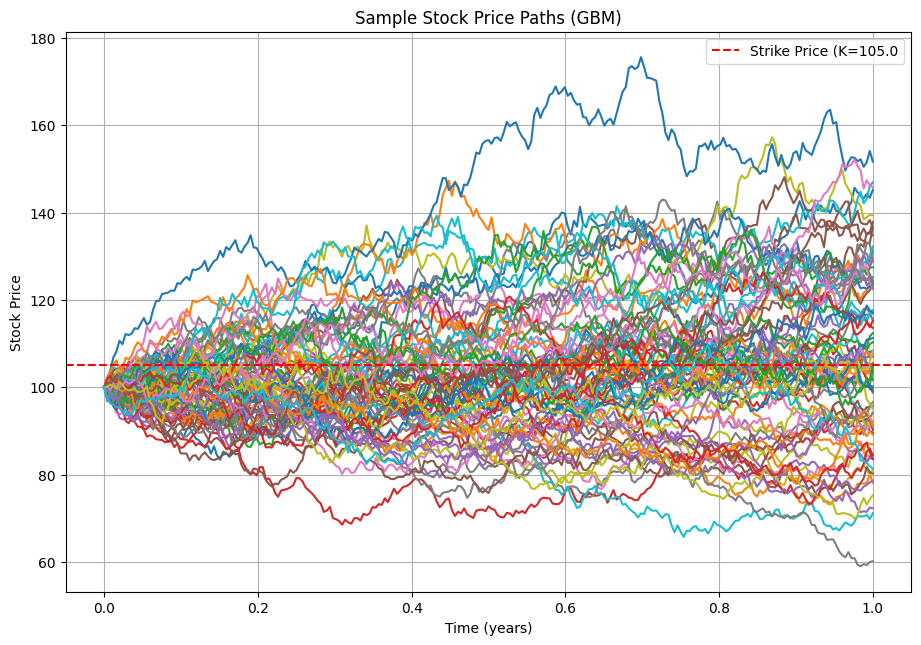

In [7]:
# Visualization 1: Sample stock price paths and distributions
plt.figure(figsize=(24,16))
plt.subplot(2, 2, 1)
# Plot the first 10 stock price paths to see the simulation
for i in range(80):
    plt.plot(np.linspace(0, T, pricer.n_steps + 1), stock_paths[:, i])
plt.axhline(y=K, color = 'r', linestyle = '--', label = f'Strike Price (K={K}')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.title('Sample Stock Price Paths (GBM)')
plt.legend()
plt.grid(True)
plt.show()

This showed us that the stock prices can either go above or below the stock prices, and when the prices are above the strike price, calls are I.T.M, whereas if the prices are below the stock price, the puts are I.T.M.

<b>Visualizing the density of simulated stock prices at K.

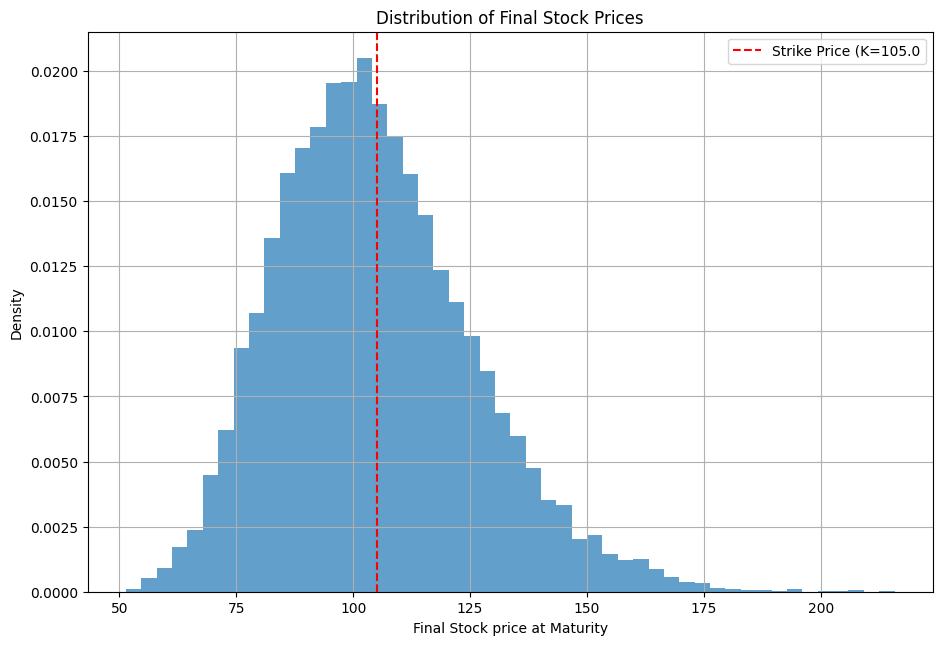

In [19]:
plt.figure(figsize=(24,16))
plt.subplot(2, 2, 2)
final_prices = stock_paths[-1]
plt.hist(final_prices, bins = 50, alpha = 0.7, density = True)
plt.axvline( x = K, color = 'r', linestyle = '--', label = f'Strike Price (K={K}')
plt.xlabel('Final Stock price at Maturity')
plt.ylabel('Density')
plt.title('Distribution of Final Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

This showed us that the GBM assumes log-normal distribution, i.e., a right skewed distribution. Here if the stocks end up on the right calls are I.T.M and if they end up on the left then puts are.

### <b>The value at expiration based on the stock price is called the option payoff, so it does not account for the price of the option, just how much the value of the option is at the time of expiration.</b>
In simple terms, an option is like paying a small fee to reserve the right to buy (or sell) a stock later — without actually buying it right now.

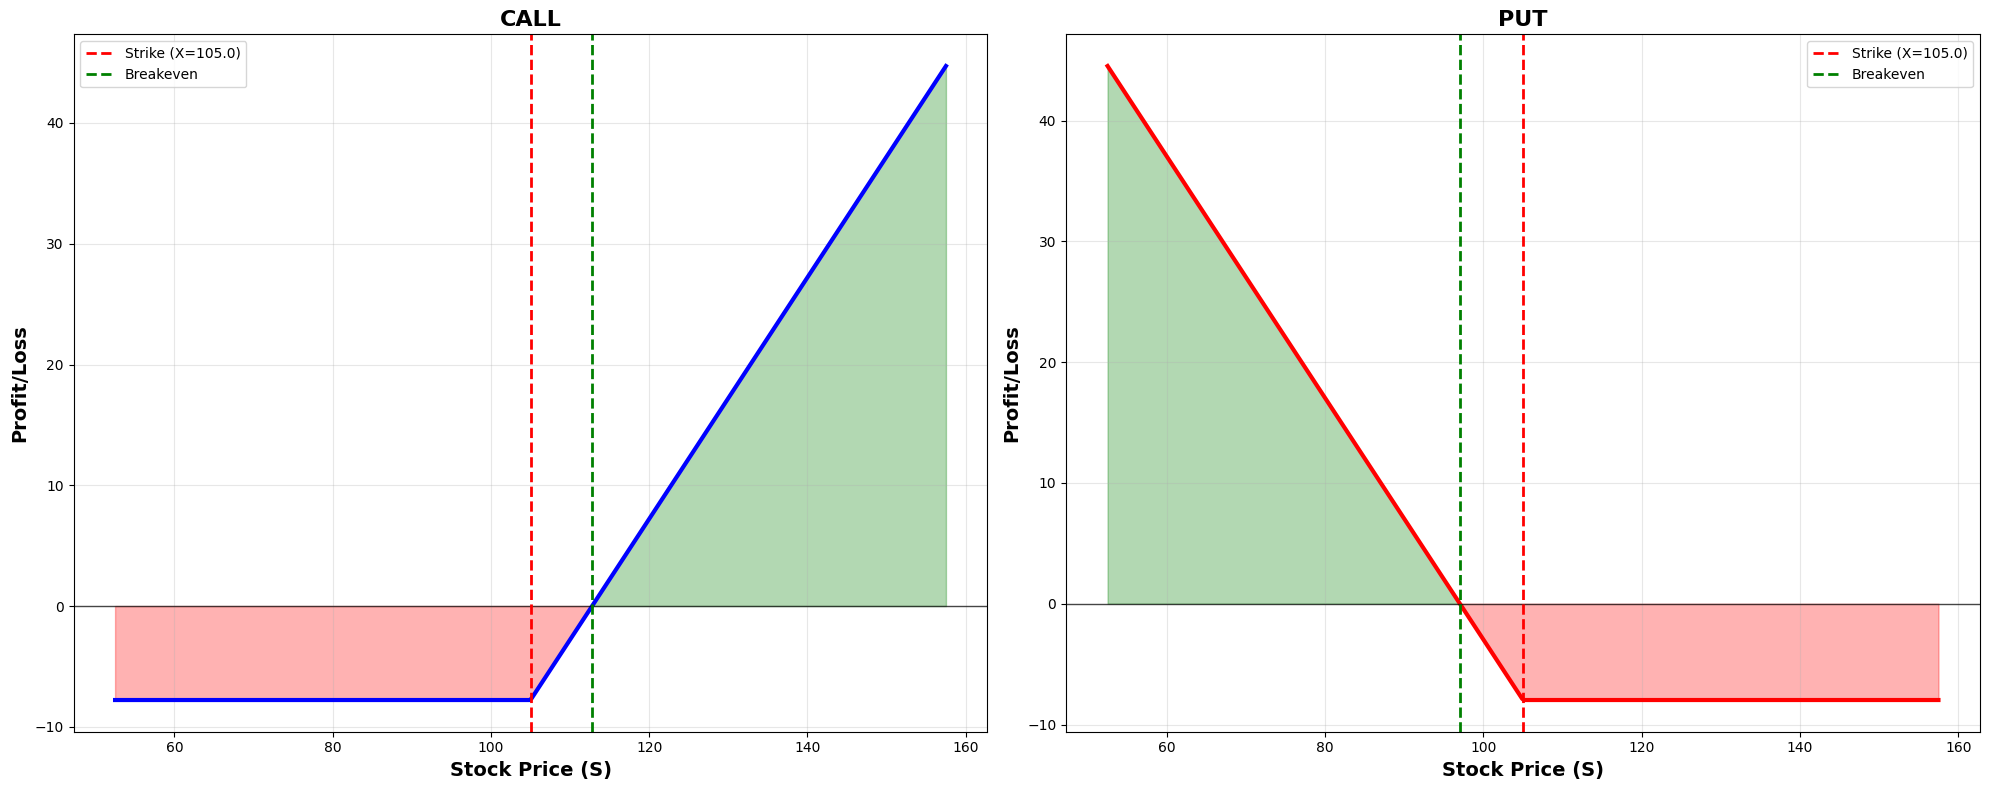

In [9]:
# Shorter version with function
def plot_option_payoff(is_call, price_mc, K, title):
    stock_prices = np.linspace(K * 0.5, K * 1.5, 500)
    payoff = np.maximum(stock_prices - K, 0) if is_call else np.maximum(K - stock_prices, 0)
    breakeven = K + price_mc if is_call else K - price_mc
    
    plt.plot(stock_prices, payoff - price_mc, 'b-' if is_call else 'r-', linewidth=3)
    plt.axhline(y=0, color='k', linewidth=1, alpha=0.7)
    plt.axvline(x=K, color='r', linestyle='--', linewidth=2, label=f'Strike (X={K})')
    plt.axvline(x=breakeven, color='g', linestyle='--', linewidth=2, label='Breakeven')
    
    if is_call:
        plt.fill_between(stock_prices, payoff - price_mc, 0, where=(stock_prices > breakeven), alpha=0.3, color='g')
        plt.fill_between(stock_prices, payoff - price_mc, 0, where=(stock_prices <= breakeven), alpha=0.3, color='r')
    else:
        plt.fill_between(stock_prices, payoff - price_mc, 0, where=(stock_prices < breakeven), alpha=0.3, color='g')
        plt.fill_between(stock_prices, payoff - price_mc, 0, where=(stock_prices >= breakeven), alpha=0.3, color='r')
    
    plt.xlabel('Stock Price (S_T)', fontsize=14, fontweight='bold')
    plt.ylabel('Profit/Loss', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Create plots
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plot_option_payoff(True, call_price_mc, K, 'CALL (long)')

plt.subplot(1, 2, 2)
plot_option_payoff(False, put_price_mc, K, 'PUT (long)')

plt.tight_layout()
plt.show()

#### These graphs show us that, puts are I.T.M when S_T < K and calls are I.T.M when S_T > K, not only that but but the loss incurred is only the price of the call/putoption itself, while the upside potential is however much profit the stocks incur.<br>

### <b>Monte Carlo estimations get more accurate as the number of simulations (n_simulations) are increased, this is called convergance analysis, the next code block is trying to show this convergance analysis in terms of he options price.

In [10]:

print("\nConvergance Analysis")
simulation_sizes = [100, 500, 1000, 5000, 10000, 20000, 30000, 50000, 75000, 100000]
mc_prices_call = []
mc_prices_put = []

for n in simulation_sizes:
    temp_pricer = european_option_pricer(S0, K, T, r, sigma, n)

    call_price, _, _, _ = temp_pricer.price_call_option()
    mc_prices_call.append(call_price)

    put_price, _, _, _ = temp_pricer.price_put_option()
    mc_prices_put.append(put_price)

    print(f"Simulations (call) = {n:5d} | Mc price = ${call_price:.4f} | Error = ${abs(call_price - call_price_bsm):.4f}")
    print(f"Simulations (Put) = {n:5d} | Mc price = ${put_price:.4f} | Error = ${abs(put_price - put_price_bsm):.4f}")
    print('-------------------------------------------------------------------')



Convergance Analysis
Simulations (call) =   100 | Mc price = $6.5913 | Error = $1.2922
Simulations (Put) =   100 | Mc price = $8.5222 | Error = $0.4596
-------------------------------------------------------------------
Simulations (call) =   500 | Mc price = $7.9782 | Error = $0.0948
Simulations (Put) =   500 | Mc price = $8.1680 | Error = $0.1054
-------------------------------------------------------------------
Simulations (call) =  1000 | Mc price = $7.7413 | Error = $0.1421
Simulations (Put) =  1000 | Mc price = $8.0608 | Error = $0.0019
-------------------------------------------------------------------
Simulations (call) =  5000 | Mc price = $7.9279 | Error = $0.0445
Simulations (Put) =  5000 | Mc price = $8.1786 | Error = $0.1160
-------------------------------------------------------------------
Simulations (call) = 10000 | Mc price = $7.7200 | Error = $0.1634
Simulations (Put) = 10000 | Mc price = $8.0369 | Error = $0.0257
---------------------------------------------------

#### <b>Plotting the different simulation sizes and comparing to the Black Scholes Merton fomula

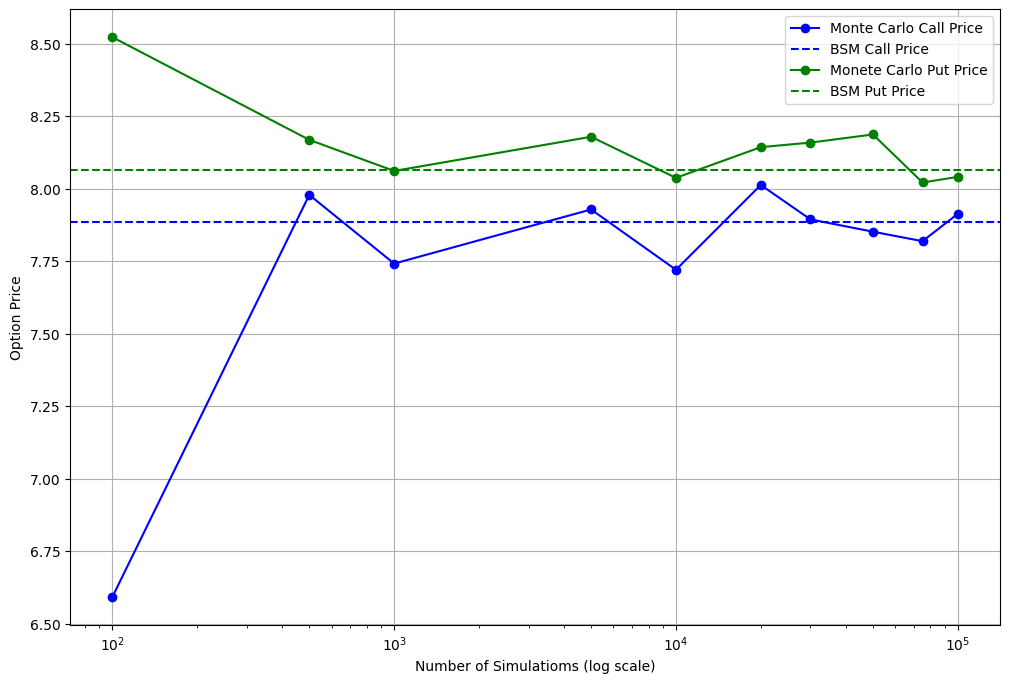

In [11]:
# Plotting the convergance
plt.figure(figsize = (12, 8))

# Plotting Call Prices
plt.plot(simulation_sizes, mc_prices_call, 'bo-', label = 'Monte Carlo Call Price')
plt.axhline(y = call_price_bsm, color = 'b', linestyle = '--', label = 'BSM Call Price')

# Plotting Put Prices
plt.plot(simulation_sizes, mc_prices_put, 'go-', label = 'Monete Carlo Put Price')
plt.axhline(y = put_price_bsm, color = 'g', linestyle = '--', label = 'BSM Put Price')

# log scale for x-axis
plt.xscale('log')
plt.xlabel('Number of Simulatioms (log scale)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

So, the visulizations show that, as the number of simulations increase, the MC prices get closer to the BSM prices.

#### <b>The next cell is foing to be an interactive analysis cell, which can take different Strike prices. How strike prices influence call and put options will also be studied.

In [12]:
user_input = input("Enter strike prices separated by commas (e.g., 95,100,105): ")
strikes = [float(s.strip()) for s in user_input.split(",")]

print("\nTesting different strike prices:")

for strike in strikes:
    pricer_test = european_option_pricer(S0, strike, T, r, sigma, 5000)
    
    # Price call option
    call_price, _, _, _ = pricer_test.price_call_option()
    bs_call_price = black_scholes_merton_call(S0, strike, T, r, sigma)
    
    # Price put option
    put_price, _, _, _ = pricer_test.price_put_option()
    bs_put_price = black_scholes_merton_put(S0, strike, T, r, sigma)
    
    # Print results
    print(f"K=${strike}:")
    print(f"  Call -> MC=£{call_price:.4f}, BS=£{bs_call_price:.4f}, Diff=£{abs(call_price-bs_call_price):.4f}")
    print(f"  Put  -> MC=£{put_price:.4f}, BS=£{bs_put_price:.4f}, Diff=£{abs(put_price-bs_put_price):.4f}")
    print('---------------------------------------------------')



Testing different strike prices:
K=$95.0:
  Call -> MC=£13.2251, BS=£13.1686, Diff=£0.0565
  Put  -> MC=£3.7291, BS=£3.8069, Diff=£0.0778
---------------------------------------------------


Lets look at the sample stock price paths too as the strike prices change

### <b>Creating a visualization to more clearly represent what this means

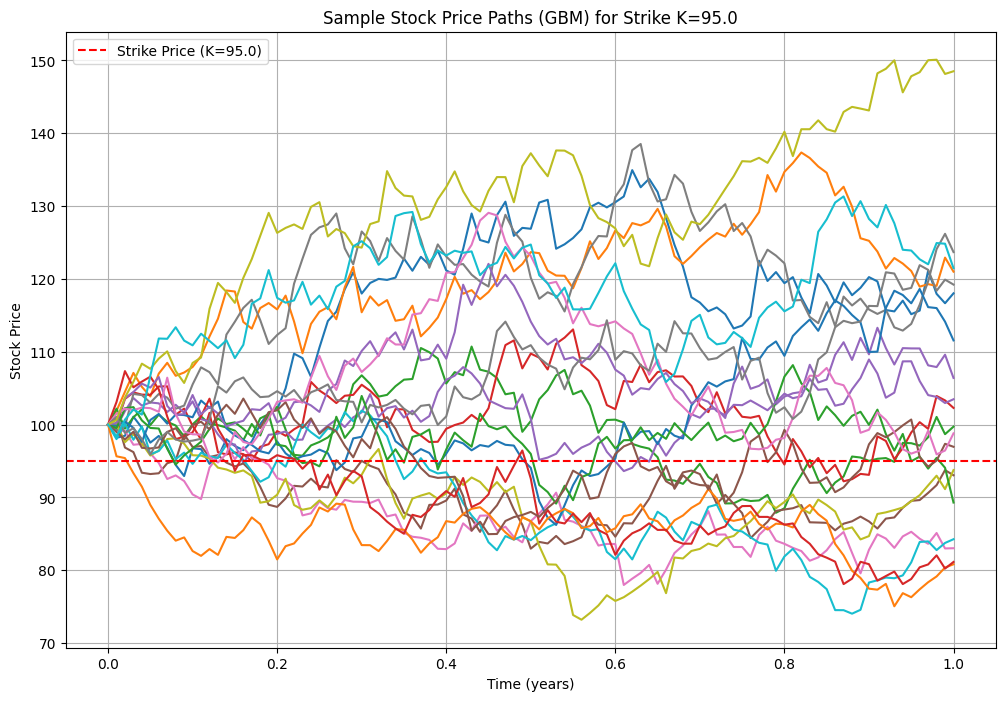

In [22]:
n_steps = 100
n_paths = 20
dt = T / n_steps
stock_paths = np.zeros((n_steps + 1, n_paths))
stock_paths[0] = S0

for t in range(1, n_steps + 1):
    z = np.random.standard_normal(n_paths)
    stock_paths[t] = stock_paths[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

# Plot stock paths for each strike price
for K in strikes:
    plt.figure(figsize=(12, 8))
    for i in range(n_paths):
        plt.plot(np.linspace(0, T, n_steps + 1), stock_paths[:, i])
    plt.axhline(y=K, color='r', linestyle='--', label=f'Strike Price (K={K})')
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')
    plt.title(f'Sample Stock Price Paths (GBM) for Strike K={K}')
    plt.legend()
    plt.grid(True)
    plt.show()

#### We see that if the strike price is higher, there is less chance of the call ending up I.T.M, hence the option price is cheaper. <br>
### Not just that , but all the parameters directly and inversely affect the option price
#### <b>for a call,</b>
#### higher underlying price(S0) means -> more expensive call
#### higher volatility(sigma) -> more chances of exceeding strike price -> more expensive call
#### higher risk free rate(r) -> more valuable call -> higher price (because BS)
#### time to maturity(T) -> more expensive call
#### higher strike price(K) means -> less expensive call<br>

#### <b>for a put,</b>
#### higher strike price(K) means -> more expensive put
#### higher volatility(sigma) -> more chances of exceeding strike price -> more expensive put
#### time to maturity(T) -> more expensive put
#### higher risk free rate(r) -> less valuable put -> lower price (because BSM discounts the r.f.r)
##### higher underlying price(S0) means -> less expensive put

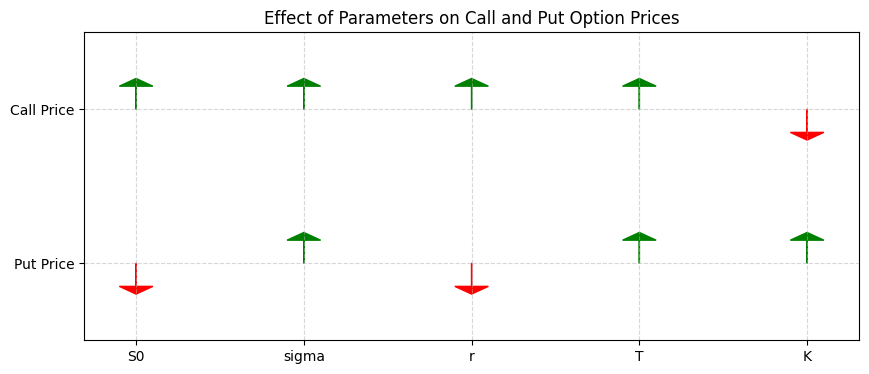

In [14]:
# Parameters and their effects on Call (+1 = up, -1 = down)
parameters = ["S0", "sigma", "r", "T", "K"]
call_effects = [1, 1, 1, 1, -1]
put_effects  = [-1, 1, -1, 1, 1]

# Create the figure
fig, ax = plt.subplots(figsize=(10, 4))

# Plot call effects
for i, effect in enumerate(call_effects):
    if effect == 1:
        ax.arrow(i, 1, 0, 0.3, head_width=0.2, head_length=0.1, fc='green', ec='green')
    else:
        ax.arrow(i, 1, 0, -0.3, head_width=0.2, head_length=0.1, fc='red', ec='red')

# Plot put effects
for i, effect in enumerate(put_effects):
    if effect == 1:
        ax.arrow(i, -1, 0, 0.3, head_width=0.2, head_length=0.1, fc='green', ec='green')
    else:
        ax.arrow(i, -1, 0, -0.3, head_width=0.2, head_length=0.1, fc='red', ec='red')

# Labels and aesthetics
ax.set_xticks(range(len(parameters)))
ax.set_xticklabels(parameters)
ax.set_yticks([1, -1])
ax.set_yticklabels(["Call Price", "Put Price"])
ax.set_title("Effect of Parameters on Call and Put Option Prices")
ax.set_ylim(-2, 2)
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

So, now it is clear the effects of each parameter on the stock price.